# Table of Contents
1. [Preprocessing](#preprocessing)
2. [Features](#feats)
3. [Random Forest Model](#rf)
4. [Permutation Importance](#pi)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.inspection import permutation_importance

## Preprocessing
<a class="anchor" id="preprocessing"></a>

In [3]:
tt=pd.read_csv('col_full_train')

In [4]:
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [5]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [7]:
train=tt[tt['TARGET'].notnull()]
test = tt[tt['TARGET'].isnull()]
target = train['TARGET']
train.head()

,Unnamed: 0,NEW_EXT_SOURCES_MEAN,prev_score_mean,buro_score_sum,prev_score_max,external_1_refill,EXT_SOURCE_2,INTEREST,app EXT_SOURCE_2 * DAYS_EMPLOYED,buro_score_max,...,NEW_INC_PER_CHLD,APPROVED_INTEREST_PREV_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,60_DAYSAMT_INSTALMENT_SUM,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN,TARGET
0,0,0.161787,0.206183,1.225013,0.206183,0.571834,0.262949,0.152945,-167.498254,0.309351,...,202500.0,0.113589,15.0,0.000000,9251.775,9.000000,62345.52,1.000000,19.353584,1.0
1,1,0.466757,0.069942,-0.129214,0.094636,0.571834,0.622246,0.106132,-739.227981,-0.012531,...,270000.0,0.234765,35.0,0.071429,6737.310,14.666667,29250.00,0.868825,5.399568,0.0
2,2,0.642739,0.167387,-0.025644,0.167387,0.513285,0.555912,-1.000000,-125.080219,-0.000968,...,67500.0,0.210678,35.0,0.250000,5357.250,5.000000,29250.00,1.207699,3.753045,0.0
3,3,0.650442,0.147371,-0.026713,0.247083,0.667749,0.650442,0.139296,-1976.692297,0.037497,...,135000.0,0.306664,35.0,0.095238,2482.920,14.666667,58055.04,0.943934,9.230206,0.0
4,4,0.322738,0.145626,-0.027718,0.209901,0.566480,0.322738,0.153404,-980.478916,-0.027718,...,121500.0,0.409463,35.0,0.045455,1834.290,12.333333,32075.28,0.791139,7.968206,0.0


In [8]:
train, test = remove_missing_columns(train,test)
train['TARGET']=target
train.head()

There are 1 columns with greater than 90% missing values.


,Unnamed: 0,NEW_EXT_SOURCES_MEAN,prev_score_mean,buro_score_sum,prev_score_max,external_1_refill,EXT_SOURCE_2,INTEREST,app EXT_SOURCE_2 * DAYS_EMPLOYED,buro_score_max,...,NEW_INC_PER_CHLD,APPROVED_INTEREST_PREV_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,60_DAYSAMT_INSTALMENT_SUM,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN,TARGET
0,0,0.161787,0.206183,1.225013,0.206183,0.571834,0.262949,0.152945,-167.498254,0.309351,...,202500.0,0.113589,15.0,0.000000,9251.775,9.000000,62345.52,1.000000,19.353584,1.0
1,1,0.466757,0.069942,-0.129214,0.094636,0.571834,0.622246,0.106132,-739.227981,-0.012531,...,270000.0,0.234765,35.0,0.071429,6737.310,14.666667,29250.00,0.868825,5.399568,0.0
2,2,0.642739,0.167387,-0.025644,0.167387,0.513285,0.555912,-1.000000,-125.080219,-0.000968,...,67500.0,0.210678,35.0,0.250000,5357.250,5.000000,29250.00,1.207699,3.753045,0.0
3,3,0.650442,0.147371,-0.026713,0.247083,0.667749,0.650442,0.139296,-1976.692297,0.037497,...,135000.0,0.306664,35.0,0.095238,2482.920,14.666667,58055.04,0.943934,9.230206,0.0
4,4,0.322738,0.145626,-0.027718,0.209901,0.566480,0.322738,0.153404,-980.478916,-0.027718,...,121500.0,0.409463,35.0,0.045455,1834.290,12.333333,32075.28,0.791139,7.968206,0.0


In [9]:
train=train.replace([np.inf, -np.inf], np.nan)
train.head()

,Unnamed: 0,NEW_EXT_SOURCES_MEAN,prev_score_mean,buro_score_sum,prev_score_max,external_1_refill,EXT_SOURCE_2,INTEREST,app EXT_SOURCE_2 * DAYS_EMPLOYED,buro_score_max,...,NEW_INC_PER_CHLD,APPROVED_INTEREST_PREV_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,60_DAYSAMT_INSTALMENT_SUM,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN,TARGET
0,0,0.161787,0.206183,1.225013,0.206183,0.571834,0.262949,0.152945,-167.498254,0.309351,...,202500.0,0.113589,15.0,0.000000,9251.775,9.000000,62345.52,1.000000,19.353584,1.0
1,1,0.466757,0.069942,-0.129214,0.094636,0.571834,0.622246,0.106132,-739.227981,-0.012531,...,270000.0,0.234765,35.0,0.071429,6737.310,14.666667,29250.00,0.868825,5.399568,0.0
2,2,0.642739,0.167387,-0.025644,0.167387,0.513285,0.555912,-1.000000,-125.080219,-0.000968,...,67500.0,0.210678,35.0,0.250000,5357.250,5.000000,29250.00,1.207699,3.753045,0.0
3,3,0.650442,0.147371,-0.026713,0.247083,0.667749,0.650442,0.139296,-1976.692297,0.037497,...,135000.0,0.306664,35.0,0.095238,2482.920,14.666667,58055.04,0.943934,9.230206,0.0
4,4,0.322738,0.145626,-0.027718,0.209901,0.566480,0.322738,0.153404,-980.478916,-0.027718,...,121500.0,0.409463,35.0,0.045455,1834.290,12.333333,32075.28,0.791139,7.968206,0.0


In [10]:
train.fillna(train.median(),inplace=True)
train.head()

,Unnamed: 0,NEW_EXT_SOURCES_MEAN,prev_score_mean,buro_score_sum,prev_score_max,external_1_refill,EXT_SOURCE_2,INTEREST,app EXT_SOURCE_2 * DAYS_EMPLOYED,buro_score_max,...,NEW_INC_PER_CHLD,APPROVED_INTEREST_PREV_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,APPROVED_AMT_ANNUITY_MIN,PREV_HOUR_APPR_PROCESS_START_MEAN,60_DAYSAMT_INSTALMENT_SUM,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN,TARGET
0,0,0.161787,0.206183,1.225013,0.206183,0.571834,0.262949,0.152945,-167.498254,0.309351,...,202500.0,0.113589,15.0,0.000000,9251.775,9.000000,62345.52,1.000000,19.353584,1.0
1,1,0.466757,0.069942,-0.129214,0.094636,0.571834,0.622246,0.106132,-739.227981,-0.012531,...,270000.0,0.234765,35.0,0.071429,6737.310,14.666667,29250.00,0.868825,5.399568,0.0
2,2,0.642739,0.167387,-0.025644,0.167387,0.513285,0.555912,-1.000000,-125.080219,-0.000968,...,67500.0,0.210678,35.0,0.250000,5357.250,5.000000,29250.00,1.207699,3.753045,0.0
3,3,0.650442,0.147371,-0.026713,0.247083,0.667749,0.650442,0.139296,-1976.692297,0.037497,...,135000.0,0.306664,35.0,0.095238,2482.920,14.666667,58055.04,0.943934,9.230206,0.0
4,4,0.322738,0.145626,-0.027718,0.209901,0.566480,0.322738,0.153404,-980.478916,-0.027718,...,121500.0,0.409463,35.0,0.045455,1834.290,12.333333,32075.28,0.791139,7.968206,0.0


In [11]:
#train.to_csv(r'vif_import.csv')

In [12]:
#top 100 features from lgbm
top100=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'buro_score_sum', 'prev_score_max',
       'buro_score_mean', 'external_1_refill', 'EXT_SOURCE_2', 'INTEREST',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 'buro_score_max', 'prev_score_last',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'DOWN_PAYMENT', 'EXT_SOURCE_3',
       'buro_score_recent2y_sum', 'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'CNT_PAYMENT', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 / DAYS_BIRTH', 'DAYS_BIRTH', 'LATE_PAYMENT',
       'app EXT_SOURCE_3 / DAYS_BIRTH', 'CRED_UTIL_2',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 'external_3_refill', 'CODE_GENDER',
       'AMT_CREDIT', 'NEW_CREDIT_TO_GOODS_RATIO',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_SOURCES_PROD', 'DAYS_ID_PUBLISH',
       'INSTAL_AMT_PAYMENT_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'NEW_ANNUITY_TO_INCOME_RATIO',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'INTEREST_SHARE', 'EXT_SOURCE_1',
       'buro_score_var', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'DAYS_EMPLOYED', 'POS_MONTHS_BALANCE_MAX', 'AGE_INT',
       'CLOSED_DAYS_CREDIT_MAX', 'prev_score_var',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'app EXT_SOURCE_1 * EXT_SOURCE_3',
       'OWN_CAR_AGE', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'POS_MONTHS_BALANCE_MEAN',
       'INSTAL_AMT_INSTALMENT_SUM',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NEW_CAR_TO_BIRTH_RATIO', 'APPROVED_DAYS_DECISION_MAX',
       'INSTAL_DPD_MEAN', 'buro_score_last', 'POS_COUNT', 'DAYS_REGISTRATION',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'PREV_DAYS_DECISION_MAX',
       'NAME_FAMILY_STATUS_Married', 'PREV_length_of_loan_MEAN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'NEW_CAR_TO_EMPLOY_RATIO', 'INSTAL_AMT_PAYMENT_MIN',
       'NEW_CREDIT_TO_INCOME_RATIO', 'PREV_days_late_due_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'ACTIVE_AMT_CREDIT_SUM_MAX', 'prev_score_recent2y_sum',
       'NEW_PHONE_TO_BIRTH_RATIO', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX', '60_DAYSAMT_PAYMENT_MIN',
       'INSTAL_DBD_SUM', 'APPROVED_DAYS_DECISION_MEAN', 'BURO_DAYS_CREDIT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'DAYS_LAST_PHONE_CHANGE',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_days_late_due_MIN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MEAN', 'NEW_DOC_IND_KURT',
       'INSTAL_AMT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN']

In [13]:
# top 200 features from lgbm
top200=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'buro_score_sum', 'prev_score_max',
       'buro_score_mean', 'external_1_refill', 'EXT_SOURCE_2', 'INTEREST',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 'buro_score_max', 'prev_score_last',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'DOWN_PAYMENT', 'EXT_SOURCE_3',
       'buro_score_recent2y_sum', 'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'CNT_PAYMENT', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 / DAYS_BIRTH', 'DAYS_BIRTH', 'LATE_PAYMENT',
       'app EXT_SOURCE_3 / DAYS_BIRTH', 'CRED_UTIL_2',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 'external_3_refill', 'CODE_GENDER',
       'AMT_CREDIT', 'NEW_CREDIT_TO_GOODS_RATIO',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_SOURCES_PROD', 'DAYS_ID_PUBLISH',
       'INSTAL_AMT_PAYMENT_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'NEW_ANNUITY_TO_INCOME_RATIO',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'INTEREST_SHARE', 'EXT_SOURCE_1',
       'buro_score_var', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'DAYS_EMPLOYED', 'POS_MONTHS_BALANCE_MAX', 'AGE_INT',
       'CLOSED_DAYS_CREDIT_MAX', 'prev_score_var',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'app EXT_SOURCE_1 * EXT_SOURCE_3',
       'OWN_CAR_AGE', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'POS_MONTHS_BALANCE_MEAN',
       'INSTAL_AMT_INSTALMENT_SUM',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NEW_CAR_TO_BIRTH_RATIO', 'APPROVED_DAYS_DECISION_MAX',
       'INSTAL_DPD_MEAN', 'buro_score_last', 'POS_COUNT', 'DAYS_REGISTRATION',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'PREV_DAYS_DECISION_MAX',
       'NAME_FAMILY_STATUS_Married', 'PREV_length_of_loan_MEAN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'NEW_CAR_TO_EMPLOY_RATIO', 'INSTAL_AMT_PAYMENT_MIN',
       'NEW_CREDIT_TO_INCOME_RATIO', 'PREV_days_late_due_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'ACTIVE_AMT_CREDIT_SUM_MAX', 'prev_score_recent2y_sum',
       'NEW_PHONE_TO_BIRTH_RATIO', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX', '60_DAYSAMT_PAYMENT_MIN',
       'INSTAL_DBD_SUM', 'APPROVED_DAYS_DECISION_MEAN', 'BURO_DAYS_CREDIT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'DAYS_LAST_PHONE_CHANGE',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_days_late_due_MIN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MEAN', 'NEW_DOC_IND_KURT',
       'INSTAL_AMT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 
        'NEW_SCORES_STD', 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'INSTAL_PAYMENT_PERC_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MAX', 'prev_score_sum',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'PREV_APP_CREDIT_PERC_VAR',
       'BURO_STATUS_0_MEAN_MEAN', 'INSTAL_PAYMENT_PERC_MEAN',
       'BURO_AMT_CREDIT_DEBT_RATE_MEAN', 'APPROVED_APP_CREDIT_PERC_VAR',
       'CLOSED_DAYS_CREDIT_VAR', 'CLOSED_AMT_CREDIT_SUM_SUM',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
       'PREV_length_of_loan_MAX', 'BURO_DAYS_CREDIT_MEAN',
       'INSTAL_PAYMENT_DIFF_SUM', 'BURO_AMT_CREDIT_SUM_MAX',
       'PREV_CNT_PAYMENT_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
       'APPROVED_AMT_DOWN_PAYMENT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MIN', 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
       'APPROVED_INTEREST_SHARE_PREV_MEAN', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_MEAN', 'NEW_INC_PER_CHLD', 'INSTAL_DPD_SUM',
       'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
       'AMT_INCOME_TOTAL', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
       'NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN', 'INSTAL_AMT_INSTALMENT_MAX',
       'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'APPROVED_INTEREST_PREV_MAX',
       'CLOSED_AMT_CREDIT_SUM_MAX', 'ACTIVE_DAYS_CREDIT_MIN',
       'PREV_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX',
       'POS_MONTHS_BALANCE_MIN', 'NEW_RATIO_BURO_DAYS_CREDIT_MEAN',
       'PREV_INTEREST_SHARE_PREV_MEAN', 'APPROVED_CNT_PAYMENT_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MIN', 'INSTAL_AMT_INSTALMENT_MEAN',
       'ACTIVE_DAYS_CREDIT_VAR', 'PREV_INTEREST_PREV_MAX',
       'INSTAL_AMT_PAYMENT_MAX', 'APPROVED_AMT_CREDIT_MAX',
       'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
       'PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN', 'APPROVED_DAYS_DECISION_MIN',
       'BURO_CREDIT_TYPE_Consumer credit_MEAN',
       '60_DAYSDAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_ANNUITY_MIN',
       'PREV_AMT_ANNUITY_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'PREV_AMT_DOWN_PAYMENT_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MEAN',
       'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_AMT_CREDIT_DEBT_RATE_SUM',
       'INSTAL_COUNT', 'TOTALAREA_MODE', 'BURO_DAYS_CREDIT_VAR',
       'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN', '60_DAYSAMT_INSTALMENT_SUM',
       'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'APPROVED_length_of_loan_MEAN',
       'INSTAL_PAYMENT_PERC_VAR', 'BURO_STATUS_C_MEAN_MEAN',
       'INSTAL_PAYMENT_DIFF_MAX', 'PREV_APP_CREDIT_PERC_MAX',
       'PREV_AMT_ANNUITY_MIN', 'APPROVED_CNT_PAYMENT_SUM', 'FLAG_WORK_PHONE',
       'APPROVED_APP_CREDIT_PERC_MIN', 'APPROVED_HOUR_APPR_PROCESS_START_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_MONTHS_BALANCE_SIZE_SUM',
       'REGION_RATING_CLIENT_W_CITY_3', 'PREV_DAYS_DECISION_MIN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
       'APPROVED_INTEREST_PREV_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MIN',
       '90_DAYSAMT_PAYMENT_MIN', 'BURO_DAYS_CREDIT_MIN', '60_DAYSDBD_MEAN']

In [14]:
#spearman hierarchy ward reduction inconsistency level 1
sp1=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'EXT_SOURCE_3',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'CODE_GENDER',
 'AMT_CREDIT',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'NEW_CREDIT_TO_ANNUITY_RATIO/3',
 'NEW_SOURCES_PROD',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'REGION_POPULATION_RELATIVE',
 'POS_MONTHS_BALANCE_MAX',
 'AGE_INT',
 'CLOSED_DAYS_CREDIT_MAX',
 'prev_score_var',
 'BURO_AMT_CREDIT_DEBT_RATE_VAR',
 'OWN_CAR_AGE',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NEW_CAR_TO_BIRTH_RATIO',
 'APPROVED_DAYS_DECISION_MAX',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'DAYS_REGISTRATION',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
 'ACTIVE_DAYS_CREDIT_MAX',
 'NAME_FAMILY_STATUS_Married',
 'PREV_length_of_loan_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'NEW_CAR_TO_EMPLOY_RATIO',
 'INSTAL_AMT_PAYMENT_MIN',
 'NEW_CREDIT_TO_INCOME_RATIO',
 'PREV_days_late_due_MEAN',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'prev_score_recent2y_sum',
 'NEW_PHONE_TO_BIRTH_RATIO',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 '60_DAYSAMT_PAYMENT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MEAN',
 'NEW_DOC_IND_KURT',
 'INSTAL_AMT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'NEW_SCORES_STD',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'INSTAL_PAYMENT_PERC_SUM',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'PREV_APP_CREDIT_PERC_VAR',
 'BURO_STATUS_0_MEAN_MEAN',
 'INSTAL_PAYMENT_PERC_MEAN',
 'CLOSED_DAYS_CREDIT_VAR',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'PREV_length_of_loan_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MIN',
 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'NEW_INC_PER_CHLD',
 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_AMT_INSTALMENT_MAX',
 'APPROVED_INTEREST_PREV_MAX',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_MONTHS_BALANCE_MIN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_VAR',
 'APPROVED_AMT_CREDIT_MAX',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
 'BURO_CREDIT_TYPE_Consumer credit_MEAN',
 '60_DAYSDAYS_ENTRY_PAYMENT_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'TOTALAREA_MODE',
 'BURO_DAYS_CREDIT_VAR',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN',
 '60_DAYSAMT_INSTALMENT_SUM',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'INSTAL_PAYMENT_PERC_VAR',
 'BURO_STATUS_C_MEAN_MEAN',
 'PREV_APP_CREDIT_PERC_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'FLAG_WORK_PHONE',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'REGION_RATING_CLIENT_W_CITY_3',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
 'APPROVED_INTEREST_PREV_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 '60_DAYSDBD_MEAN']
#137

In [15]:
#features after statsmodel regression, removing features with p>0.05
feature_cols=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'INTEREST',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'POS_COUNT',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'NEW_INC_PER_CHLD',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN']

## Features selected through Spearman Hierarchy Ward calculation
<a class="anchor" id="feats"></a>

In [16]:
#spearman ward with incconsistency level 2
feature_cols=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'ACTIVE_DAYS_CREDIT_MAX',
 'PREV_length_of_loan_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_days_late_due_MEAN',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 '60_DAYSAMT_PAYMENT_MIN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_AMT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'PREV_APP_CREDIT_PERC_VAR',
 'CLOSED_DAYS_CREDIT_VAR',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'NEW_INC_PER_CHLD',
 'APPROVED_INTEREST_PREV_MAX',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 '60_DAYSAMT_INSTALMENT_SUM',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN']

## Random Forest Model
<a class="anchor" id="rf"></a>

In [17]:
feature_cols = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index','Unnamed: 0']]
y = train.TARGET
y1=train.TARGET
X = train[feature_cols]
X1 = train[feature_cols]

In [18]:
len(feature_cols)

73

In [19]:
clf = RandomForestClassifier(
    n_estimators=60,
    criterion='gini',
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=19,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [20]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [21]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('RF Features (avg over folds)')
    plt.tight_layout
    plt.savefig('rf_importances01.png')

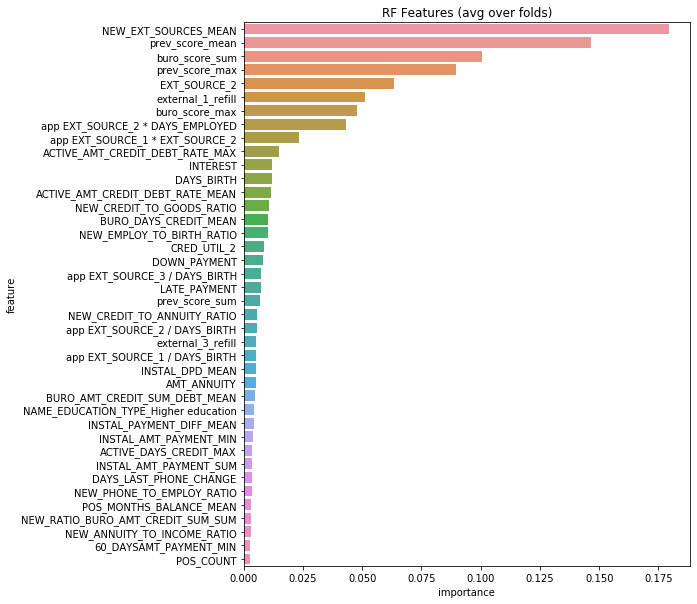

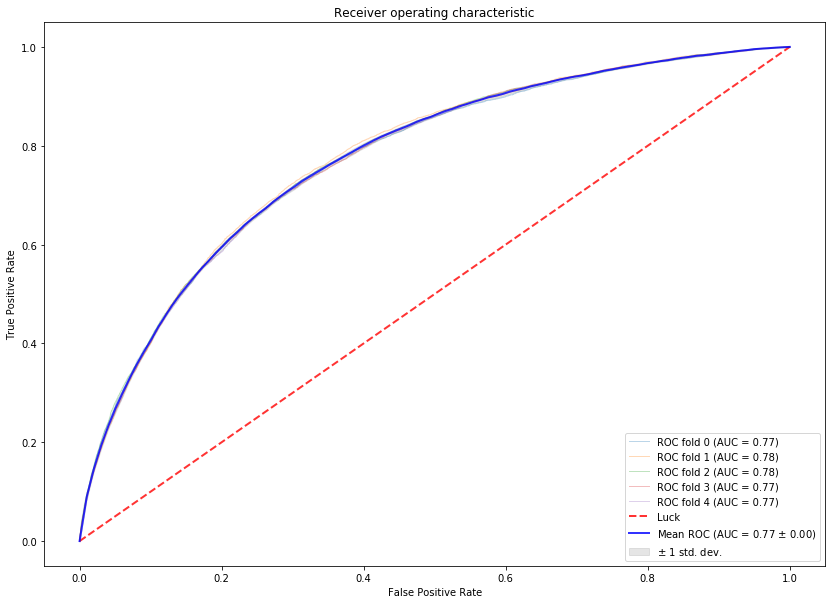

,AUC Train,AUC Test,f1-score Test
0,0.802569,0.773252,0.559263
1,0.802192,0.777651,0.562986
2,0.802504,0.776320,0.560844
3,0.802290,0.773795,0.560370
4,0.803192,0.773217,0.563886


In [31]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    model=clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    y_pred = clf.predict(X.iloc[test])
    f1_test = f1_score(y.iloc[test],y_pred, average='macro',zero_division=1)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, f1_test))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = model.feature_importances_
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',"f1-score Test"])

In [23]:
feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
NEW_EXT_SOURCES_MEAN,0.179416
prev_score_mean,0.146432
buro_score_sum,0.100487
prev_score_max,0.089415
EXT_SOURCE_2,0.063244
...,...
POS_NAME_CONTRACT_STATUS_Active_MEAN,0.000958
ACTIVE_AMT_CREDIT_DEBT_RATE_VAR,0.000950
NEW_INC_PER_CHLD,0.000929
CLOSED_MONTHS_BALANCE_SIZE_MEAN,0.000903


In [24]:
#feat.length

## Permutation importance
<a class="anchor" id="pi"></a>

In [26]:
model2=clf.fit(X1[feature_cols],y1)

In [27]:
X2=X1[feature_cols]

### Sk-learn feature importance

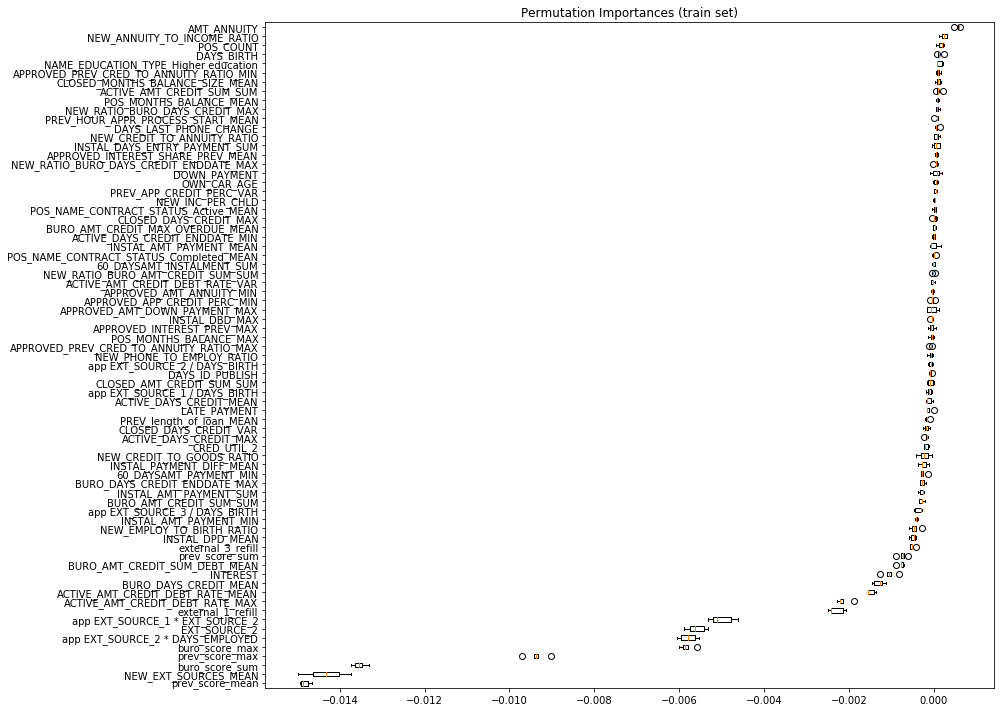

In [28]:
result = permutation_importance(model2, X1[feature_cols], y1, n_repeats=5,
                                random_state=19, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,10))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X2.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [29]:
result.importances

array([[-1.43281291e-02, -1.37427766e-02, -1.40256970e-02,
        -1.46403171e-02, -1.49752689e-02],
       [-1.47573876e-02, -1.48712062e-02, -1.49102297e-02,
        -1.49362454e-02, -1.46533250e-02],
       [-1.35379032e-02, -1.34696121e-02, -1.36419659e-02,
        -1.37330207e-02, -1.33005102e-02],
       [-9.01117698e-03, -9.42092375e-03, -9.37214437e-03,
        -9.71685197e-03, -9.32986891e-03],
       [-2.42270908e-03, -2.42921299e-03, -2.48124433e-03,
        -2.14954456e-03, -2.06824560e-03],
       [-5.61938427e-03, -5.88604487e-03, -5.74295870e-03,
        -5.31695213e-03, -5.42101481e-03],
       [-1.00810713e-03, -1.06339043e-03, -1.26175989e-03,
        -8.09737665e-04, -1.10566589e-03],
       [-6.05189475e-03, -5.62588819e-03, -5.78523416e-03,
        -5.54133727e-03, -5.96409187e-03],
       [-6.01287125e-03, -5.78523416e-03, -5.91531250e-03,
        -5.85677724e-03, -5.58361273e-03],
       [-7.47950453e-05, -3.25195849e-05, -1.46338132e-04,
        -1.07314630e-04

### eli5 feature importance (same results as above)

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model2, random_state=19).fit(X1[feature_cols], y1)
eli5.show_weights(perm, feature_names = X2.columns.tolist())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macO

Weight,Feature
0.0006 ± 0.0002,AMT_ANNUITY
0.0003 ± 0.0004,DAYS_BIRTH
0.0002 ± 0.0001,NEW_ANNUITY_TO_INCOME_RATIO
0.0002 ± 0.0001,POS_COUNT
0.0001 ± 0.0001,NAME_EDUCATION_TYPE_Higher education
0.0001 ± 0.0004,NEW_CREDIT_TO_ANNUITY_RATIO
0.0001 ± 0.0001,APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN
0.0001 ± 0.0001,DAYS_LAST_PHONE_CHANGE
0.0001 ± 0.0001,ACTIVE_AMT_CREDIT_SUM_SUM
0.0001 ± 0.0000,CLOSED_MONTHS_BALANCE_SIZE_MEAN
